In [21]:
from dotenv import load_dotenv
from rich import print

load_dotenv()
%load_ext rich
%load_ext autoreload
%autoreload 2

The rich extension is already loaded. To reload it, use:
  %reload_ext rich
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [28]:
import requests

response = requests.post(
    url="http://localhost:8000/learn/", params={"user_input": "ackerman function"}
)


In [34]:
response.json()['lesson_plan']



{
    'title': 'Understanding and Applying the Ackermann Function',
    'topics': [
        {
            'objective': 'Understand the mathematical definition and properties of the Ackermann function.',
            'videos': ['KMnSsmLr6EI?t=8400', 'ygmr01x24Y8?t=1740', '5h5rQ3Y1Cfo?t=2520'],
            'description': 'This topic covers the mathematical definition, properties, and theoretical background of the Ackermann function, focusing on its significance in computer science.',
            'suggested_activities': [
                'Watch the provided videos and take notes on the key properties and definitions of the Ackermann function.',
                'Research and summarize the historical context and development of the Ackermann function.',
                'Participate in a discussion forum to share insights and ask questions about the Ackermann function.'
            ]
        },
        {
            'objective': 'Implement the Ackermann function in Python and analyze its beha

## App

In [22]:
from youtube_lesson_planner.graph import create_graph

graph = create_graph()

In [23]:
response = graph.invoke({"original_query": "quant finance"})

[0:tasks] Starting step 0 with 1 task:
- __start__ -> {'original_query': 'quant finance'}
[0:writes] Finished step 0 with writes to 1 channel:
- original_query -> 'quant finance'
[1:tasks] Starting step 1 with 1 task:
- objectives -> {'learning_objectives': None,
 'lesson_plan': None,
 'original_query': 'quant finance',
 'rewritten_query': None,
 'transcripts_status': None,
 'vectorstore': None,
 'videos': None}
[1:writes] Finished step 1 with writes to 1 channel:
- learning_objectives -> LearningObjectivesList(objectives=[LearningObjectives(index=1, objective='Understand the fundamental concepts of quantitative finance, including risk management and financial modeling.'), LearningObjectives(index=2, objective='Apply mathematical and statistical methods to analyze financial markets and instruments.'), LearningObjectives(index=3, objective='Develop and backtest trading strategies using quantitative techniques.'), LearningObjectives(index=4, objective='Utilize programming languages, such

In [24]:
response['lesson_plan']


LessonPlan(
    title='Introduction to Quantitative Finance',
    topics=[
        Topic(
            objective='Understand the fundamental concepts of quantitative finance, including risk management and financial modeling.',
            videos=['hfIUstzHs9A', 'vneJieU5qlg'],
            description='This topic introduces the basic principles of quantitative finance, covering key concepts such as risk management, financial modeling, and foundational theories.',
            suggested_activities=[
                'Watch the provided videos and take notes on key concepts.',
                "Read a foundational textbook on quantitative finance, such as 'Quantitative Finance for Dummies'.",
                'Participate in an online forum to discuss the concepts with peers.'
            ]
        ),
        Topic(
            objective='Apply mathematical and statistical methods to analyze financial markets and instruments.',
            videos=['pWNAtUwnBS8', 'Yq0QkCxoTHM'],
            de

## Flow

In [12]:
import json
from youtube_lesson_planner.video import YouTubeVideo

In [ ]:

embeddings = OpenAIEmbeddings(model="text-embedding-3-small", dimensions=512)
qdrant_client = QdrantClient(
    location=":memory:",
)
qdrant_client.create_collection(
    "youtube_transcripts-1", {"size": 512, "distance": "Cosine"}
)

vectorstore = Qdrant(
    client=qdrant_client,
    collection_name="youtube_transcripts-1",
    embeddings=embeddings,
)

In [13]:
import json

with open(
    "../search_data/search_results_Generative AI basics explained.json",
    "r",
) as f:
    items = json.load(f)["items"]

yt_videos = {
    item["id"]["videoId"]: YouTubeVideo(
        video_id=item["id"]["videoId"],
        title=item["snippet"]["title"],
        description=item["snippet"]["description"],
        published_at=item["snippet"]["publishedAt"],
        channel_title=item["snippet"]["channelTitle"],
        chunk_time_limit=30,
    )
    for item in items
}



In [17]:
from youtube_lesson_planner.nodes.get_transcripts import get_transcripts

vs = get_transcripts(list(yt_videos.values()))


[[Document(metadata={'start_seconds': 0, 'start_timestamp': '00:00:00', 'source': 'https://www.youtube.com/watch?v=pWNAtUwnBS8&t=0s', 'title': 'What is Generative AI?', 'video_id': 'pWNAtUwnBS8'}, page_content="NARRATOR: What is generative\nartificial intelligence or generative AI? Generative AI is an artificial\nintelligence technology that can create new content in\ntext, image, music, and video forms. Businesses are exceptionally\nexcited by the possibilities of specialized\ngenerative AI models because they can be trained\non an organization's own corporate data and\nthey can collaborate with knowledge workers\nto dramatically boost productivity."), Document(metadata={'start_seconds': 30, 'start_timestamp': '00:00:30', 'source': 'https://www.youtube.com/watch?v=pWNAtUwnBS8&t=30s', 'title': 'What is Generative AI?', 'video_id': 'pWNAtUwnBS8'}, page_content='Estimates value the productivity\nboost at up to $8 trillion a year to the global economy. An example of generative\nAI is chat

In [ ]:
response = generate_learning_objectives("how to learn spanish")

In [ ]:
response

In [ ]:
query = rewrite("how to learn spanish", response)

In [ ]:
query

In [ ]:
videos = search_youtube(query.optimized_query)

In [ ]:
from langchain_openai import OpenAIEmbeddings
from langchain_qdrant import Qdrant
from qdrant_client import QdrantClient

embeddings = OpenAIEmbeddings(model="text-embedding-3-small", dimensions=1536)
qdrant_client = QdrantClient(
    location=":memory:",
)
qdrant_client.create_collection("youtube_transcripts", {"size": 1536, "distance": "Cosine"})

In [ ]:
vectorstore = Qdrant(
    client=qdrant_client,
    collection_name="youtube_transcripts",
    embeddings=embeddings,
)

In [ ]:
transcripts = get_transcripts(videos, vectorstore)

In [ ]:
transcripts

In [ ]:
lesson_plan = generate_plan("how to learn spanish", response, vectorstore)

In [ ]:
lesson_plan

## LangGraph

In [6]:
from langchain_openai import OpenAIEmbeddings
from langchain_qdrant import Qdrant
from langgraph.graph import END, StateGraph
from qdrant_client import QdrantClient


In [7]:
from youtube_lesson_planner.nodes.generate_plan import generate_plan
from youtube_lesson_planner.nodes.get_transcripts import get_transcripts
from youtube_lesson_planner.nodes.learning_objectives import (
    generate_learning_objectives,
)
from youtube_lesson_planner.nodes.query_rewriter import rewrite
from youtube_lesson_planner.nodes.search_videos import search_youtube
from youtube_lesson_planner.schemas import AgentState


In [8]:
def create_vectorstore(state: AgentState) -> AgentState:
    embeddings = OpenAIEmbeddings(model="text-embedding-3-small", dimensions=1536)
    qdrant_client = QdrantClient(
        location=":memory:",
    )
    qdrant_client.create_collection(
        "youtube_transcripts", {"size": 1536, "distance": "Cosine"}
    )

    vectorstore = Qdrant(
        client=qdrant_client,
        collection_name="youtube_transcripts",
        embeddings=embeddings,
    )

    return {
        "vectorstore": vectorstore,
    }


In [9]:
def learning_objectives(state: AgentState) -> AgentState:
    query = state["original_query"]

    objectives = generate_learning_objectives(query)

    return {
        "learning_objectives": objectives,
    }


In [10]:
def rewrite_query(state: AgentState) -> AgentState:
    query = state["original_query"]
    objectives = state["learning_objectives"]

    rewritten_query = rewrite(query, objectives)

    return {
        "rewritten_query": rewritten_query.optimized_query,
    }


In [11]:
def search(state: AgentState) -> AgentState:
    optimized_query = state["rewritten_query"]
    videos = search_youtube(optimized_query, max_results=10)

    return {
        "videos": videos,
    }


In [12]:
def transcripts(state: AgentState) -> AgentState:
    videos = state["videos"]
    vectorstore = state["vectorstore"]

    _ = get_transcripts(list(videos.values()), vectorstore)

    return {"transcripts_status": True}

In [13]:
def generate(state: AgentState) -> AgentState:
    query = state["original_query"]
    objectives = state["learning_objectives"]
    vectorstore = state["vectorstore"]

    lesson_plan = generate_plan(query, objectives, vectorstore)

    return {
        "lesson_plan": lesson_plan,
    }


In [14]:
workflow = StateGraph(AgentState)


workflow.add_node("make_vectorstore", create_vectorstore)
workflow.add_node("objectives", learning_objectives)
workflow.add_node("rewrite_query", rewrite_query)
workflow.add_node("search", search)
workflow.add_node("transcripts", transcripts)
workflow.add_node("generate", generate)

workflow.set_entry_point("make_vectorstore")

workflow.add_edge("make_vectorstore", "objectives")
workflow.add_edge("objectives", "rewrite_query")
workflow.add_edge("rewrite_query", "search")
workflow.add_edge("search", "transcripts")
workflow.add_edge("transcripts", "generate")
workflow.add_edge("generate", END)

graph = workflow.compile(debug=True)


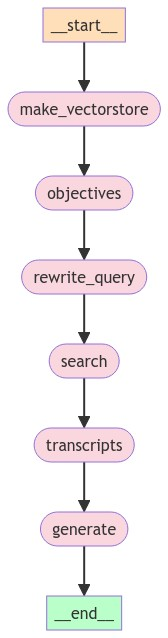

In [15]:
from IPython.display import Image

Image(graph.get_graph().draw_mermaid_png())

In [1]:
response = graph.invoke({"original_query": "build a house in fortnite"})

NameError: name 'graph' is not defined

In [44]:
response['lesson_plan']


LessonPlan(
    title='Building a House in Fortnite',
    topics=[
        Topic(
            objective='Understand the basic building mechanics and controls in Fortnite',
            videos=[
                Fortnite for Beginners: What Should You Learn First? by Billy Bicep - z0wnM20Noi8 | Live on Twitch: https://twitch.tv/Billy_Bicep Thanks for using code “billy-bicep” in the item shop Want a Fortnite Coach? Join my ...,
                5 Fortnite Battle Royale Building Tips by SXVXN - djha41CuxOE | Fortnite Battle Royale Building Tips. This video is all about the best 5 Beginner Fortnite Battle Royale Building Tips. In this video ...
            ],
            description='This topic covers the essential building mechanics and controls in Fortnite, including how to place walls, floors, ramps, and roofs. It will help learners get comfortable with the basic building tools and commands.',
            suggested_activities=[
                'Watch the provided videos to understand the 